In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
df = pd.read_csv("../data/flights_small.csv" , sep = ";")
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,5,20,3,WN,2433,N638SW,BNA,LGA,1150,...,1919.0,259.0,0,0,NaN,1.0,0.0,38.0,220.0,0.0
1,2015,11,23,1,AA,2256,N481AA,DFW,IAH,1550,...,1643.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,3,24,2,B6,585,N355JB,ROC,JFK,1840,...,1947.0,-20.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,10,7,3,OO,4813,N910EV,11193,15919,1135,...,1213.0,-18.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,8,2,7,DL,951,N335NW,SLC,MCO,2250,...,440.0,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


###  Dataset Completo puede encontrarse en:
https://www.kaggle.com/datasets/usdot/flight-delays?select=flights.csv

En los archivos del curso tienes la versión reducida: *flights_small.csv*

# Validación de modelos avanzada

In [3]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, KFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

df_filtrado = df.dropna(subset=["AIRLINE", "DEPARTURE_DELAY", "ARRIVAL_DELAY"])

df_filtrado.loc[:,["LATE"]] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE"]]
y = df_filtrado["LATE"]

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(modelo_rf, X, y, cv=5)
print("Accuracy medio: " + str(np.round(scores.mean(), 3)))

Accuracy medio: 0.908


In [4]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}
resultados = cross_validate(modelo_rf, X, y, cv=5, scoring=scoring)
print("F1 medio: " + str(np.round(resultados['test_f1'].mean(), 3)))

F1 medio: 0.737


In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
modelo_logreg = LogisticRegression()
scores_strat = cross_val_score(modelo_logreg, X, y, cv=skf)
print("Accuracy con StratifiedKFold: " + str(np.round(scores_strat.mean(), 3)))

Accuracy con StratifiedKFold: 0.931


In [9]:
y.value_counts()

LATE
0    8008
1    1807
Name: count, dtype: int64

In [10]:
from sklearn.tree import DecisionTreeClassifier
modelo_tree = DecisionTreeClassifier(random_state=42, max_depth=3)
df_filtrado = df_filtrado.sample(3000)
X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE"]]
y = df_filtrado["LATE"]
loo = LeaveOneOut()

scores = cross_val_score(modelo_tree, X, y, cv=loo)

print("Accuracy medio con LOO: " + str(np.round(scores.mean(), 3)))

Accuracy medio con LOO: 0.913


# Selección de parámetros en Machine Learning

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint

df_filtrado = df.dropna(subset=["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE"])
df_filtrado.loc[:,["LATE"]] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE"]]
y = df_filtrado["LATE"]

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}
modelo = RandomForestClassifier(random_state=0)
grid = GridSearchCV(modelo, param_grid, cv=3)
grid.fit(X, y)
print("Mejores parámetros: " + str(grid.best_params_))
print("Mejor score: " + str(np.round(grid.best_score_, 3)))

Mejores parámetros: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Mejor score: 0.931


In [13]:
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(2, 20),
    'min_samples_split': randint(2, 10)
}
rand_search = RandomizedSearchCV(modelo, param_dist, n_iter=10, cv=3, random_state=42)
rand_search.fit(X, y)
print("Mejores parámetros (random): " + str(rand_search.best_params_))

Mejores parámetros (random): {'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 197}


In [16]:
param_log = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
logreg = LogisticRegression()
grid_log = GridSearchCV(logreg, param_log, cv=5)
grid_log.fit(X, y)
print("Mejor C: " + str(grid_log.best_params_['C']))

Mejor C: 0.1


In [17]:
mejor_rf = grid.best_estimator_
mejor_log = grid_log.best_estimator_

from sklearn.metrics import accuracy_score

pred_rf = mejor_rf.predict(X)
pred_log = mejor_log.predict(X)

acc_rf = accuracy_score(y, pred_rf)
acc_log = accuracy_score(y, pred_log)

print("Accuracy RF: " + str(np.round(acc_rf, 3)))
print("Accuracy LogReg: " + str(np.round(acc_log, 3)))

Accuracy RF: 0.932
Accuracy LogReg: 0.931


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # Necesario
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
    'max_depth': [None, 5, 10,20],
    'min_samples_split': [2, 5,10],
    'bootstrap' : [True,False]
}

halving = HalvingGridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    resource='n_estimators',
    max_resources=200,
    min_resources=50,
    factor=2,
    scoring='f1',
    cv=3,
    random_state=0,
)

halving.fit(X,y)

print("Mejores parámetros: " + str(halving.best_params_))
print("Mejor score: " + str(np.round(halving.best_score_, 3)))

Mejores parámetros: {'bootstrap': False, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score: 0.789


In [19]:
modelo_final = RandomForestClassifier(**halving.best_params_).fit(X,y)

In [20]:
modelo_final

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",False
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

# Optimización del proceso de entrenamiento

In [84]:
# !pip install category_encoders

In [21]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

In [33]:
df_filtrado = df[["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE", "AIR_TIME", "TAXI_IN", "TAXI_OUT",
    "SCHEDULED_DEPARTURE", "SCHEDULED_TIME", "SCHEDULED_ARRIVAL",
    "AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "DAY_OF_WEEK", "MONTH"]]

df_filtrado.loc[:, ["LATE"]] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

df_sample = df_filtrado.sample(1000, random_state=42)

X = df_sample[[
    "DEPARTURE_DELAY", "DISTANCE", "AIR_TIME", "TAXI_IN", "TAXI_OUT",
    "SCHEDULED_DEPARTURE", "SCHEDULED_TIME", "SCHEDULED_ARRIVAL",
    "AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "DAY_OF_WEEK", "MONTH"
]]
y = df_sample["LATE"]

variables_numericas = [
    "DEPARTURE_DELAY", "DISTANCE", "AIR_TIME", "TAXI_IN", "TAXI_OUT",
    "SCHEDULED_DEPARTURE", "SCHEDULED_TIME", "SCHEDULED_ARRIVAL"
]
variables_categoricas_frecuentes = ["AIRLINE", "ORIGIN_AIRPORT"]
variables_categoricas_codificadas = ["DESTINATION_AIRPORT", "DAY_OF_WEEK", "MONTH"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [34]:
X_train["AIRLINE"].value_counts(normalize=True)

AIRLINE
WN    0.227143
DL    0.165714
AA    0.132857
OO    0.102857
EV    0.085714
UA    0.075714
MQ    0.048571
B6    0.047143
US    0.037143
AS    0.022857
NK    0.018571
HA    0.012857
F9    0.012857
VX    0.010000
Name: proportion, dtype: float64

In [35]:
top_airlines = X_train["AIRLINE"].value_counts(normalize=True)
top_airlines = top_airlines[top_airlines > 0.02].index.tolist()
print(top_airlines)
X_train["AIRLINE"] = X_train["AIRLINE"].where(X_train["AIRLINE"].isin(top_airlines), "OTROS")
X_test["AIRLINE"] = X_test["AIRLINE"].where(X_test["AIRLINE"].isin(top_airlines), "OTROS")

['WN', 'DL', 'AA', 'OO', 'EV', 'UA', 'MQ', 'B6', 'US', 'AS']


In [42]:

top_airports = X_train["ORIGIN_AIRPORT"].value_counts().nlargest(10).index.tolist()
X_train["ORIGIN_AIRPORT"] = X_train["ORIGIN_AIRPORT"].where(X_train["ORIGIN_AIRPORT"].isin(top_airports), "OTROS")
X_test["ORIGIN_AIRPORT"] = X_test["ORIGIN_AIRPORT"].where(X_test["ORIGIN_AIRPORT"].isin(top_airports), "OTROS")

In [51]:
preprocesado = ColumnTransformer([
    ("num", IterativeImputer(random_state=42), variables_numericas),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), variables_categoricas_frecuentes),
    ("target", TargetEncoder(), variables_categoricas_codificadas)
])

pipeline = Pipeline([
    ("preproc", preprocesado),
    ("modelo", XGBClassifier(eval_metric='logloss', n_jobs=-1))
])

param_grid = {
    "modelo__max_depth": [3, 5, 7, 10],
    "modelo__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "modelo__n_estimators": [300],
    "modelo__subsample": [0.6, 0.8, 1.0],
    "modelo__colsample_bytree": [0.6, 0.8, 1.0],
    "modelo__gamma": [0, 1, 5],
    "modelo__reg_alpha": [0, 0.1, 1],
    "modelo__reg_lambda": [0.5, 1, 2]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

halving = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    factor=2,
    scoring="accuracy",
    cv=cv,
    verbose=1,
    n_jobs=-1
)

halving.fit(X_train, y_train)
modelo_final = halving.best_estimator_

n_iterations: 6
n_required_iterations: 12
n_possible_iterations: 6
min_resources_: 12
max_resources_: 700
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 3888
n_resources: 12
Fitting 3 folds for each of 3888 candidates, totalling 11664 fits
----------
iter: 1
n_candidates: 1944
n_resources: 24
Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
----------
iter: 2
n_candidates: 972
n_resources: 48
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
----------
iter: 3
n_candidates: 486
n_resources: 96
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
----------
iter: 4
n_candidates: 243
n_resources: 192
Fitting 3 folds for each of 243 candidates, totalling 729 fits
----------
iter: 5
n_candidates: 122
n_resources: 384
Fitting 3 folds for each of 122 candidates, totalling 366 fits


In [52]:
halving.best_score_

np.float64(0.9502542650918636)

# Neural Networks en ScikitLearn

https://playground.tensorflow.org/

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
df_filtrado = df.dropna(subset=["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE"])
df_filtrado.loc[:,["LATE"]] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE"]]
y = df_filtrado["LATE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=0)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', modelo)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Resultado red neuronal simple")
print(classification_report(y_test, y_pred))

Resultado red neuronal simple
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2424
           1       0.90      0.70      0.79       521

    accuracy                           0.93      2945
   macro avg       0.92      0.84      0.87      2945
weighted avg       0.93      0.93      0.93      2945



In [54]:
modelo2 = MLPClassifier(hidden_layer_sizes=(20,), max_iter=500, random_state=0)
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', modelo2)
])
pipeline2.fit(X_train, y_train)
y_pred2 = pipeline2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2424
           1       0.89      0.71      0.79       521

    accuracy                           0.93      2945
   macro avg       0.92      0.85      0.88      2945
weighted avg       0.93      0.93      0.93      2945



In [55]:
modelo3 = MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=500, random_state=0)
pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', modelo3)
])
pipeline3.fit(X_train, y_train)
y_pred3 = pipeline3.predict(X_test)
print("Red con dos capas ocultas")
print(classification_report(y_test, y_pred3))

Red con dos capas ocultas
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2424
           1       0.90      0.69      0.78       521

    accuracy                           0.93      2945
   macro avg       0.92      0.84      0.87      2945
weighted avg       0.93      0.93      0.93      2945



In [57]:
modelo4 = MLPClassifier(hidden_layer_sizes=(20,20), solver='adam', alpha=0.01, max_iter=500, random_state=0)
pipeline4 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', modelo4)
])
pipeline4.fit(X_train, y_train)
y_pred4 = pipeline4.predict(X_test)
print("Modelo con regularización alpha=0.01")
print(classification_report(y_test, y_pred4))

Modelo con regularización alpha=0.01
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2424
           1       0.90      0.71      0.79       521

    accuracy                           0.93      2945
   macro avg       0.92      0.84      0.88      2945
weighted avg       0.93      0.93      0.93      2945



# XGBoost y algoritmos basados en árboles

In [45]:
# ! pip install xgboost

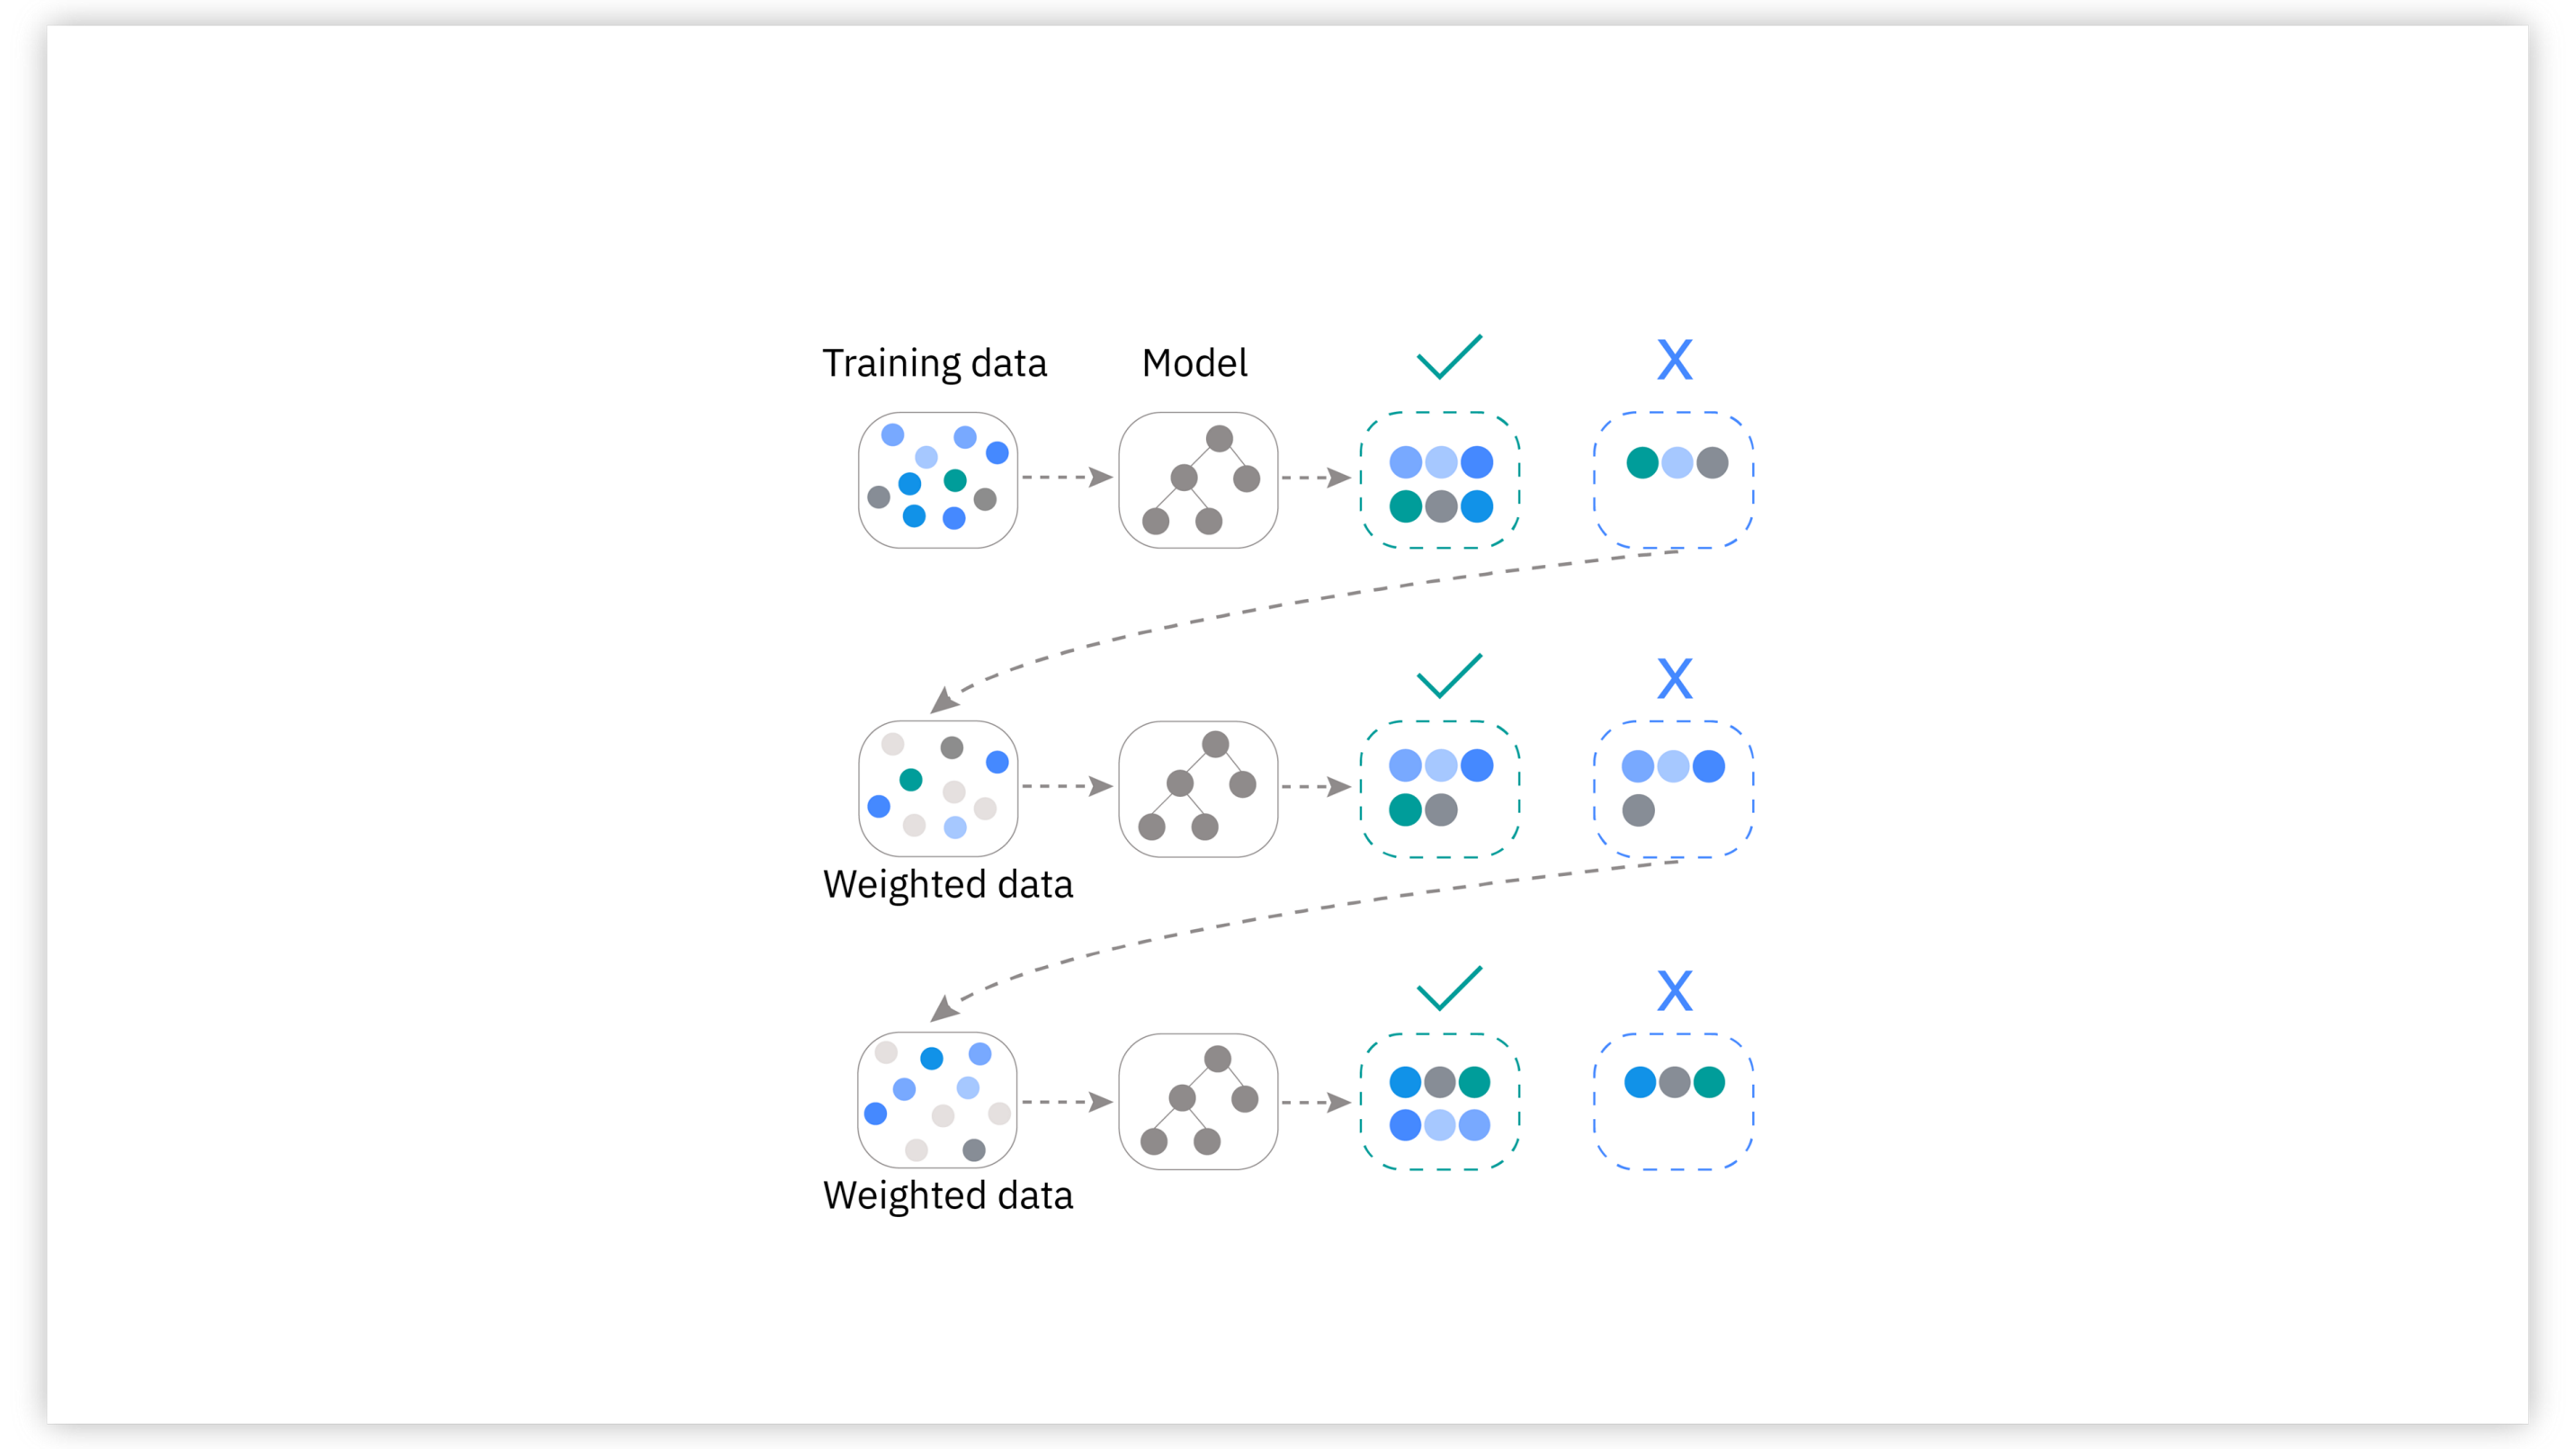

In [6]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df_filtrado = df.dropna(subset=["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE", "AIR_TIME","TAXI_IN", "TAXI_OUT"])
df_filtrado.loc[:,["LATE"]] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE","AIR_TIME","TAXI_IN", "TAXI_OUT"]]
y = df_filtrado["LATE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo = XGBClassifier(eval_metric='logloss')
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
print("Modelo básico XGBoost")
print(classification_report(y_test, y_pred))

Modelo básico XGBoost
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2424
           1       0.85      0.79      0.82       521

    accuracy                           0.94      2945
   macro avg       0.90      0.88      0.89      2945
weighted avg       0.94      0.94      0.94      2945



In [7]:
modelo2 = XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.1, eval_metric='logloss')
modelo2.fit(X_train, y_train)
y_pred2 = modelo2.predict(X_test)
print("XGBoost ajustado")
print(classification_report(y_test, y_pred2))

XGBoost ajustado
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2424
           1       0.89      0.78      0.83       521

    accuracy                           0.94      2945
   macro avg       0.92      0.88      0.90      2945
weighted avg       0.94      0.94      0.94      2945



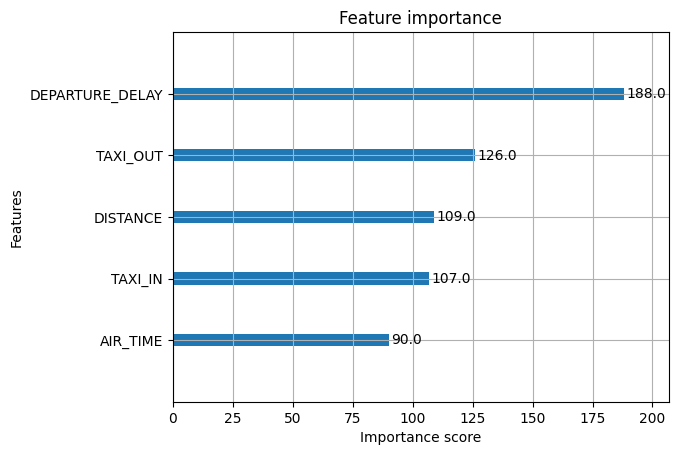

In [8]:
plot_importance(modelo2)
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy: " + str(np.round(accuracy_score(y_test, y_pred2), 3)))
print("F1: " + str(np.round(f1_score(y_test, y_pred2), 3)))
print("Matriz de confusión:")
confusion_matrix(y_test, y_pred2)


Accuracy: 0.945
F1: 0.834
Matriz de confusión:


array([[2376,   48],
       [ 114,  407]])

In [12]:
df_filtrado = df.dropna(subset=["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE", "AIR_TIME", "TAXI_IN", "TAXI_OUT", "AIRLINE"])

df_filtrado.loc[:, ["LATE"]] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

variables_numericas = ["DEPARTURE_DELAY", "DISTANCE", "AIR_TIME", "TAXI_IN", "TAXI_OUT"]
variables_categoricas = ["AIRLINE"]

X = df_filtrado[variables_numericas + variables_categoricas]
y = df_filtrado["LATE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

preprocesado = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown='ignore'), variables_categoricas)
    ],
    remainder="passthrough"  # deja pasar las numéricas sin modificar
)

pipeline = Pipeline(steps=[
    ("preprocesado", preprocesado),
    ("modelo", XGBClassifier(eval_metric='logloss'))
])

param_grid = {
    "modelo__n_estimators": [50, 100],
    "modelo__max_depth": [3, 5, 7],
    "modelo__learning_rate": [0.01, 0.1, 0.2],
    "modelo__subsample": [0.7, 1],
    "modelo__colsample_bytree": [0.7, 1]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:")
print(grid.best_params_)

y_pred = grid.predict(X_test)
print("Informe de clasificación en test:")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


Mejores hiperparámetros:
{'modelo__colsample_bytree': 1, 'modelo__learning_rate': 0.1, 'modelo__max_depth': 3, 'modelo__n_estimators': 100, 'modelo__subsample': 0.7}
Informe de clasificación en test:


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2424
           1       0.91      0.79      0.84       521

    accuracy                           0.95      2945
   macro avg       0.93      0.89      0.91      2945
weighted avg       0.95      0.95      0.95      2945



In [14]:
parametros_modelo = {k.replace("modelo__", ""): v for k, v in grid.best_params_.items()}
pipeline_final = Pipeline(steps=[
    ("preprocesado", preprocesado),
    ("modelo", XGBClassifier(**parametros_modelo, eval_metric='logloss'))
])
pipeline_final.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocesado', ...), ('modelo', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('onehot', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers conta

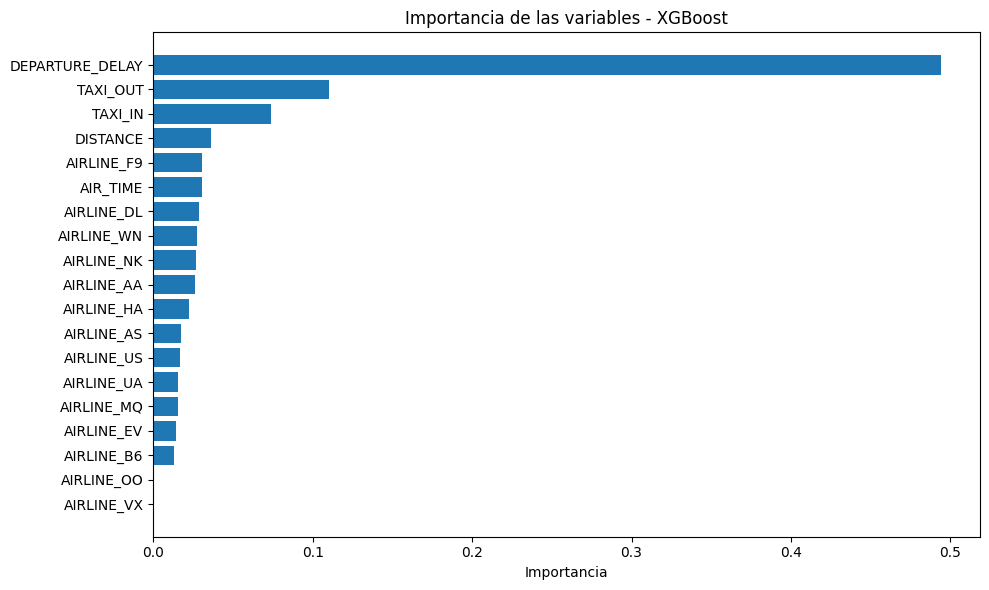

In [15]:
modelo_final = pipeline_final.named_steps["modelo"]
columnas_ohe = pipeline_final.named_steps["preprocesado"].named_transformers_["onehot"].get_feature_names_out(variables_categoricas)
nombres_columnas = np.concatenate([columnas_ohe, variables_numericas])
importancias = modelo_final.feature_importances_

importancia_df = pd.DataFrame({
    "variable": nombres_columnas,
    "importancia": importancias
}).sort_values("importancia", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importancia_df["variable"], importancia_df["importancia"])
plt.gca().invert_yaxis()
plt.title("Importancia de las variables - XGBoost")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

# SHAP Values

In [77]:
# ! pip install shap

In [16]:
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

df_filtrado = df.dropna(subset=["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE"])
df_filtrado.loc[:,["LATE"]] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE"]]
y = df_filtrado["LATE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo = XGBClassifier(eval_metric="logloss")
modelo.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

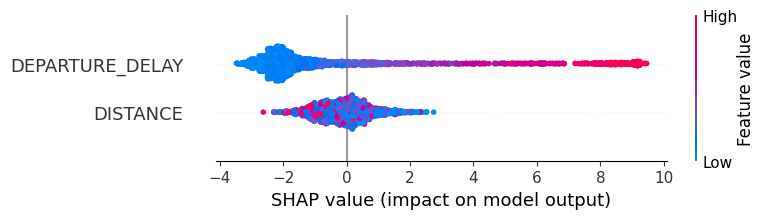

In [17]:
explainer = shap.Explainer(modelo)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

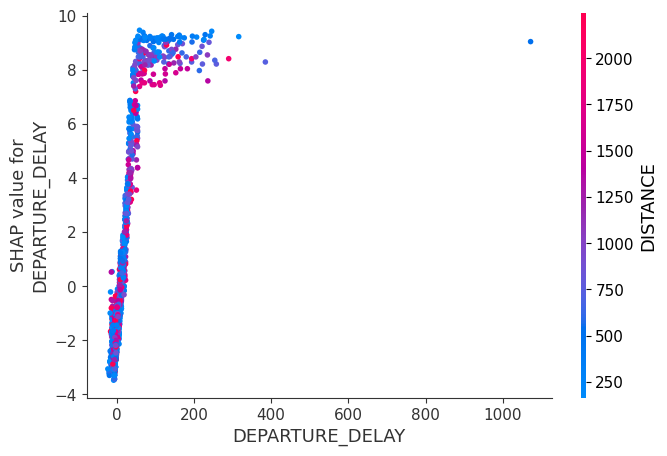

In [18]:
# Gráfico de dependencia para una variable
shap.dependence_plot("DEPARTURE_DELAY", shap_values.values, X_test)

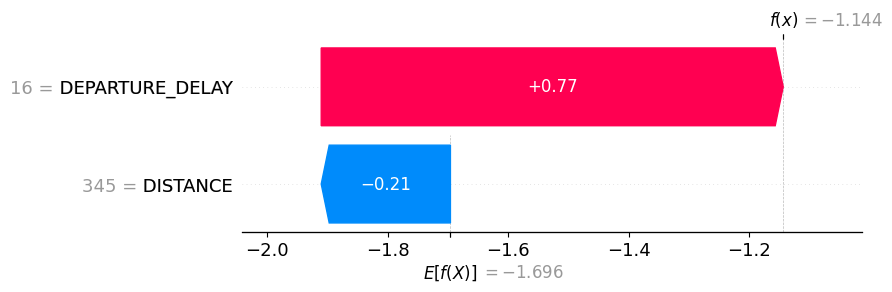

In [19]:
# Fuerza individual de una predicción concreta
shap.plots.waterfall(shap_values[0])

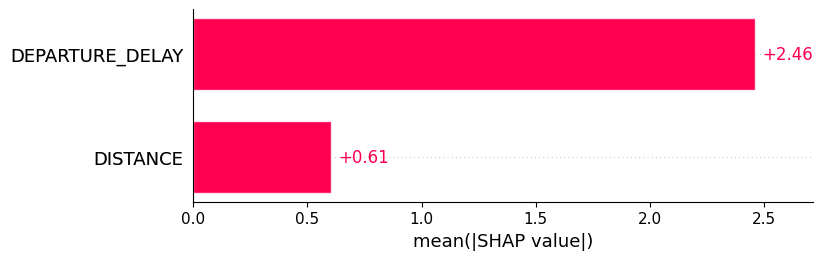

In [20]:
# Visualización completa para los primeros ejemplos
shap.plots.bar(shap_values)

# Creación de un Pipeline completo

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

df_filtrado = df.dropna(subset=["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE", "AIRLINE"])
df_filtrado.loc[:, ["LATE"]] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE", "AIRLINE"]]
y = df_filtrado["LATE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

columnas_numericas = ["DEPARTURE_DELAY", "DISTANCE"]
columnas_categoricas = ["AIRLINE"]

preprocesado = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()) # RobustScaler
    ]), columnas_numericas),
    ("cat", OneHotEncoder(handle_unknown="ignore"), columnas_categoricas)
])

pipeline = Pipeline([
    ("preprocesado", preprocesado),
    ("modelo", RandomForestClassifier(n_estimators=100, random_state=0))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Pipeline con variable categórica (AIRLINE)")
print(classification_report(y_test, y_pred))


Pipeline con variable categórica (AIRLINE)
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2424
           1       0.79      0.70      0.74       521

    accuracy                           0.91      2945
   macro avg       0.87      0.83      0.85      2945
weighted avg       0.91      0.91      0.91      2945



In [22]:
import pandas as pd

nuevo = pd.DataFrame({
    "DEPARTURE_DELAY": [99, None, 45],
    "DISTANCE": [500, 300, None],
    "AIRLINE": ["AA", "DL", "UA"]  
})

predicciones = pipeline.predict(nuevo)
print("Predicciones nuevas: " + str(predicciones))

# import joblib
# joblib.dump(pipeline, "modelo_pipeline.pkl")


Predicciones nuevas: [1 1 1]
